In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env CUDA_VISIBLE_DEVICES=0

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import sys

if os.getcwd().split("/")[-1] == "notebooks":
    %cd ..
sys.path.append(".")

import jax
import jax.numpy as jnp

/mnt/aitrics_ext/ext01/john/jax/Neural-Process-Family


In [3]:
from flax.training import checkpoints
from npf.jax.models import ( 
    AttnNP,    
    ConvNP,
)
from npf.jax.data import GPSampler, Matern52Kernel, RBFKernel, PeriodicKernel

In [20]:
from nxcl.config import load_config
config = load_config('configs/convnp.yaml')
model = ConvNP(1, **config.model.get("kwargs", {}))
state = checkpoints.restore_checkpoint(
    'outs/ConvNP/RBF/RBF/220703-051614-rocm/checkpoint_30000', target=None
)
params = state['params']

In [16]:
config = load_config('configs/attnnp.yaml')
model = AttnNP(1, **config.model.get("kwargs", {}))
state = checkpoints.restore_checkpoint(
    'outs/AttnNP/RBF/RBF/220703-054606-hzoy/checkpoint_30000', target=None
)
params = state['params']

In [21]:
key = jax.random.PRNGKey(77)
sampler = GPSampler(RBFKernel())
batch = sampler.sample_for_plot(key, batch_size=8, num_points=200)
mu, sigma = model.apply(params, 
                   x_ctx=batch.x_ctx,                    
                   y_ctx=batch.y_ctx, 
                   x_tar=batch.x_tar,
                   mask_ctx=batch.mask_ctx,
                   mask_tar=batch.mask_tar,
                   num_latents=30,
                   rngs={'sample':jax.random.PRNGKey(46)}
                   )

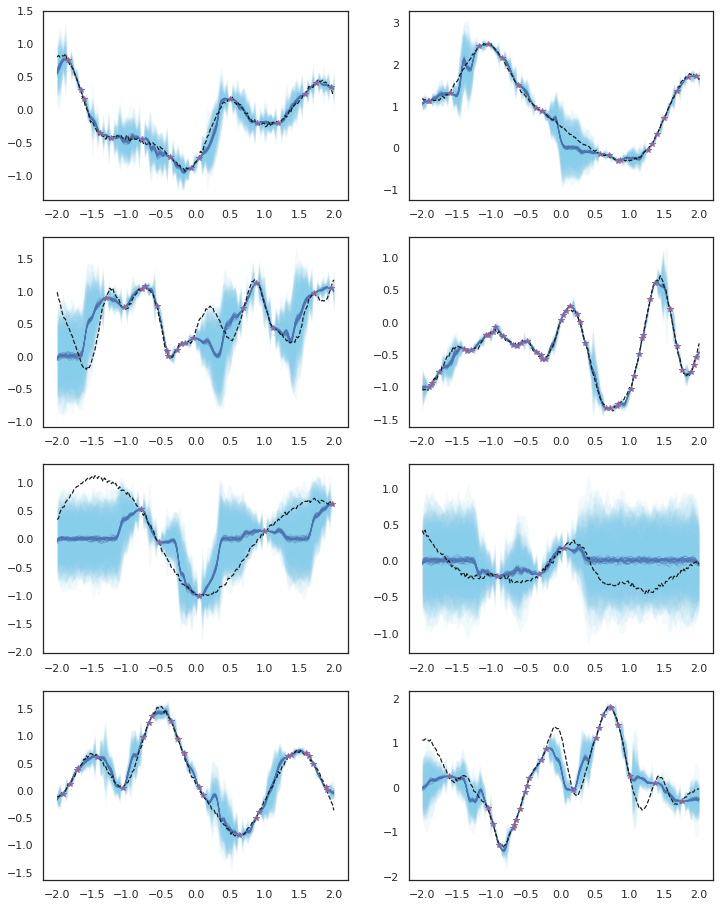

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="white")

batch_size, num_latents = batch.x_ctx.shape[0], mu.shape[1]
nrows, ncols = 4, (batch_size+3)//4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*4))
axes = axes.flatten()
for b in range(batch_size):
    mask_ctx, mask_tar = batch.mask_ctx[b], batch.mask_tar[b]
    x_ctx = np.array(batch.x_ctx[b][mask_ctx]).squeeze()
    y_ctx = np.array(batch.y_ctx[b][mask_ctx]).squeeze()
    x_tar = np.array(batch.x_tar[b][mask_tar]).squeeze()
    y_tar = np.array(batch.y_tar[b][mask_tar]).squeeze()
    for s in range(num_latents):                      
        mu_tar = np.array(mu[b][s][mask_tar]).squeeze()
        sigma_tar = np.array(sigma[b][s][mask_tar]).squeeze()
        axes[b].fill_between(x_tar, mu_tar+sigma_tar, mu_tar-sigma_tar, 
                             alpha=0.1, linewidth=0.5, facecolor='skyblue')
        axes[b].plot(x_tar, mu_tar, 'b-', linewidth=0.5, alpha=0.5)
    axes[b].plot(x_tar, y_tar, 'k--', linewidth=1.2)
    axes[b].plot(x_ctx, y_ctx, 'r*', markeredgecolor='m')  